<a href="https://colab.research.google.com/github/sheensta/retail_products_ensemble_deep_learning/blob/main/Predicting_test_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder

import joblib
import keras
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from spacy.lang.en.stop_words import STOP_WORDS
from gensim.models import word2vec
import nltk
import regex as re

Reading Test Image Data

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
test_path = '/content/drive/MyDrive/Colab Notebooks/test'
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_NLP.csv')
os.chdir(test_path)

In [ ]:
#Save and resize images (not needed after loading)
'''
def create_img_dict(files_list):
  imgid_list = []
  imgs_list = []
  for i in range(len(files_list)):
    imgid_list.append(files_list[i][:-4])
    imgs_list.append(mpimg.imread(files_list[i]))
  dict_img = dict(zip(imgid_list, imgs_list))
  return dict_img
#convert test images to array
files_list = os.listdir(test_path)
dict_img = create_img_dict(files_list)
df_img = pd.DataFrame({'ImgId': dict_img.keys(), 'array': dict_img.values()})
df_img['shape'] = [x.shape for x in list(dict_img.values())]
df_img.to_csv('/content/drive/MyDrive/Colab Notebooks/df_img_arrays.csv', index = False)
df_test_merged = df_test.merge(df_img, on = 'ImgId', how='outer')
np.save('/content/drive/MyDrive/Colab Notebooks/df_np_img_arrays.npy', df_test_merged)
'''

"\ndef create_img_dict(files_list):\n  imgid_list = []\n  imgs_list = []\n  for i in range(len(files_list)):\n    imgid_list.append(files_list[i][:-4])\n    imgs_list.append(mpimg.imread(files_list[i]))\n  dict_img = dict(zip(imgid_list, imgs_list))\n  return dict_img\n#convert test images to array\nfiles_list = os.listdir(test_path)\ndict_img = create_img_dict(files_list)\ndf_img = pd.DataFrame({'ImgId': dict_img.keys(), 'array': dict_img.values()})\ndf_img['shape'] = [x.shape for x in list(dict_img.values())]\ndf_img.to_csv('/content/drive/MyDrive/Colab Notebooks/df_img_arrays.csv', index = False)\ndf_test_merged = df_test.merge(df_img, on = 'ImgId', how='outer')\nnp.save('/content/drive/MyDrive/Colab Notebooks/df_np_img_arrays.npy', df_test_merged)\n"

In [ ]:
df_test_merged = pd.DataFrame(np.load('/content/drive/MyDrive/Colab Notebooks/df_np_img_arrays.npy', allow_pickle=True))
df_test_merged.columns = ['ImgId', 'title', 'description', 'array', 'shape']
df_test_merged.index = df_test_merged['ImgId']

In [ ]:
#Splitting the dataset by rows with only text, both image and text, and images only
df_text_only = df_test_merged.loc[(df_test_merged['shape']==(100,100)) | (pd.isnull(df_test_merged['shape']))]
df_img_text = df_test_merged.loc[(df_test_merged['shape']==(100,100,3)) & (pd.notnull(df_test_merged['description']))]
df_img_only = df_test_merged.loc[(pd.isnull(df_test_merged['description'])) & (pd.isnull(df_test_merged['description'])) & (df_test_merged['shape']==(100,100,3))]

#checking if missing any observations
len(df_text_only) + len(df_img_text) + len(df_img_only) == len(df_test_merged)

True

Reading Test Text Data

In [ ]:
#Data Preprocessing
stopwords = list(STOP_WORDS)
other_stopwords = ['nbsp', 'x']
stopwords = stopwords + other_stopwords
space_pattern = '\s+'
non_text = '[^\w]'
num_pattern = '\d'

def remove_stopwords(tokens):
    return [t for t in tokens if t not in stopwords]

def preprocess(text_string):
    text_string = str(text_string)
    text_string = text_string.lower().strip()
    text_string = " ".join(remove_stopwords(text_string.split()))
    text_string = re.sub(space_pattern, ' ', text_string)
    text_string = re.sub(num_pattern, '', text_string)
    text_string = re.sub(non_text,' ',text_string)
    text_string = re.sub('^oz{1}','ounce',text_string)
    text_string = re.sub('^s{1}','small',text_string)
    text_string = re.sub('^m{1}','medium',text_string)
    text_string = re.sub('^l{1}','large',text_string)
    return text_string

def clean_df(df, colname):
  clean_list = []
  for i in range(len(df[colname])):
    cleaned_string = preprocess(df[colname].iloc[i])
    clean_list.append(cleaned_string)
  return clean_list

In [ ]:
df_text_only['description'] = df_text_only['description'].astype(str)
df_img_text['description'] = df_img_text['description'].astype(str)
df_train['description_clean'] = df_train['description_clean'].astype(str)

df_text_only['description_clean'] = clean_df(df_text_only, 'description')
df_img_text['description_clean'] = clean_df(df_img_text, 'description')

corpus = pd.concat([df_text_only['description_clean'], df_img_text['description_clean'], df_train['description_clean']]) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
'''
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in corpus]

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
'''
#pd.DataFrame(w2v_feature_array).to_csv('/content/drive/MyDrive/models/full_models/FULL_w2v_feature_array.csv')
#len(w2v_feature_array) == len(df_text_only) + len(df_img_text) + len(df_train)
#w2v_feature_array = pd.DataFrame(w2v_feature_array)
#w2v_feature_array.index = corpus.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
w2v_feature_array = pd.read_csv('/content/drive/MyDrive/models/full_models/FULL_w2v_feature_array.csv')
w2v_feature_array = w2v_feature_array.iloc[:,1:]
w2v_feature_array.index = corpus.index

Predicting test data

In [ ]:
#RF and XGB inputs:
X_w2v_text_only = w2v_feature_array.iloc[:len(df_text_only)]
X_w2v_img_text = w2v_feature_array.iloc[len(df_text_only):len(df_img_text)+len(df_text_only)]

#NLP DL inputs:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(corpus)
#vocab_size = len(tokenizer.word_index) + 1

X_nlp_dl_text_only = list(df_text_only['description_clean'])
X_nlp_dl_img_text = list(df_img_text['description_clean'])

X_nlp_dl_text_only = tokenizer.texts_to_sequences(X_nlp_dl_text_only)
X_nlp_dl_img_text = tokenizer.texts_to_sequences(X_nlp_dl_img_text)

maxlen = 250
X_nlp_dl_text_only = pad_sequences(X_nlp_dl_text_only, padding='post', maxlen=maxlen)
X_nlp_dl_img_text = pad_sequences(X_nlp_dl_img_text, padding='post', maxlen=maxlen)

#Image inputs:
X_img_only = np.array(list(df_img_only['array']))
X_img_text = np.array(list(df_img_text['array']))

In [ ]:
#train RF model on full training data
'''
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
X_train = w2v_feature_array[len(df_img_text)+len(df_text_only):]
y = df_train['categories']
rf.fit(X_train, y)
'''

"\nfrom sklearn.ensemble import RandomForestClassifier\n\nrf = RandomForestClassifier()\nX_train = w2v_feature_array[len(df_img_text)+len(df_text_only):]\ny = df_train['categories']\nrf.fit(X_train, y)\n"

In [ ]:
#train XGB model on full training data
from xgboost import XGBClassifier

xgb = XGBClassifier(objective = 'multiclass:softmax')
xgb.fit(X_train, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
joblib.dump(xgb, '/content/drive/MyDrive/models/full_models/FULL_NLP_xgb2.pkl')
joblib.dump(rf, '/content/drive/MyDrive/models/full_models/FULL_NLP_rf2.pkl')

['/content/drive/MyDrive/models/full_models/FULL_NLP_rf2.pkl']

In [ ]:
FULL_NLP1 = load_model('/content/drive/MyDrive/models/full_models/FULL_NLP1.h5')
FULL_NLP_CNN = load_model('/content/drive/MyDrive/models/full_models/FULL_NLP_CNN.h5')
FULL_NLP_rf = joblib.load('/content/drive/MyDrive/models/full_models/FULL_NLP_rf2.pkl')
FULL_NLP_xgb = joblib.load('/content/drive/MyDrive/models/full_models/FULL_NLP_xgb2.pkl')
#FULL_resnet = load_model('/content/drive/MyDrive/models/full_models/FULL_resnet.h5')
FULL_resnet = load_model('/content/drive/MyDrive/models/full_models/FULL_resnet2.h5')

In [ ]:
FULL_NLP_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#XGB_features = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99']
XGB_features = w2v_feature_array.columns
X_w2v_text_only_xgb = X_w2v_text_only
X_w2v_text_only_xgb.columns = XGB_features
X_w2v_img_text_xgb = X_w2v_img_text
X_w2v_img_text.columns = XGB_features

In [ ]:
#NLP Classic models

#Text only
y_NLP_rf_text_only = FULL_NLP_rf.predict_proba(X_w2v_text_only)
y_NLP_xgb_text_only = FULL_NLP_xgb.predict_proba(X_w2v_text_only)

#Text and images
y_NLP_rf_img_text = FULL_NLP_rf.predict_proba(X_w2v_img_text)
y_NLP_xgb_img_text = FULL_NLP_xgb.predict_proba(X_w2v_img_text)

In [ ]:
#NLP DL models

#Text only
y_NLP_1_text_only = FULL_NLP1.predict(X_nlp_dl_text_only)
y_NLP_CNN_text_only = FULL_NLP_CNN.predict(X_nlp_dl_text_only)

#Text and images
y_NLP_1_img_text = FULL_NLP1.predict(X_nlp_dl_img_text)
y_NLP_CNN_img_text = FULL_NLP_CNN.predict(X_nlp_dl_img_text)

In [ ]:
#Image model

#Image only
y_resnet_img_only = FULL_resnet.predict(X_img_only) 

#Text and images
y_resnet_img_text = FULL_resnet.predict(X_img_text)

In [ ]:
#decode predictions
def max_prediction(prediction):
  predictions_list = []
  for i in range(len(prediction)):
    predictions_list.append(np.argmax(prediction[i]))
  return predictions_list

def ensemble_voting(list_predictions):
  preds_list_mode = [max_prediction(x) for x in list_predictions]
  mode_array = stats.mode(np.array(preds_list_mode))
  return mode_array

In [ ]:
#Ensemble modeling based on average for containing image and texts

#image text
preds_list_avg_image_text = [y_NLP_1_img_text + y_NLP_CNN_img_text + y_NLP_rf_img_text + y_NLP_xgb_img_text + y_resnet_img_text]
labels_predict_mean_img_text = sum(preds_list_avg_image_text)/5

#text only
preds_list_avg_text_only = [y_NLP_1_text_only + y_NLP_CNN_text_only + y_NLP_rf_text_only + y_NLP_xgb_text_only]
labels_predict_mean_text_only = sum(preds_list_avg_text_only)/4

#img only - no ensemble as there is only one model

In [ ]:
#getting final results

labels_image_text = max_prediction(labels_predict_mean_img_text)
labels_text_only = max_prediction(labels_predict_mean_text_only)
labels_image_only = max_prediction(y_resnet_img_only)

In [ ]:
#Re-coding the results (manually)

previous_labels_list = ['All Beauty', 'All Electronics', 'Appliances',
       'Arts, Crafts & Sewing', 'Automotive', 'Baby', 'Baby Products',
       'Beauty', 'Cell Phones & Accessories', 'Clothing, Shoes & Jewelry',
       'Electronics', 'Grocery & Gourmet Food', 'Health & Personal Care',
       'Industrial & Scientific', 'Musical Instruments',
       'Office Products', 'Patio, Lawn & Garden', 'Pet Supplies',
       'Sports & Outdoors', 'Tools & Home Improvement', 'Toys & Games']
numerical_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

di1 = dict(zip(numerical_labels, previous_labels_list))

di2 = {'Electronics':	0,
'Sports & Outdoors':	1,
'Cell Phones & Accessories':	2,
'Automotive':	3,
'Toys & Games':	4,
'Tools & Home Improvement':	5,
'Health & Personal Care':	6,
'Beauty':	7,
'Grocery & Gourmet Food':	8,
'Office Products':	9,
'Arts, Crafts & Sewing':	10,
'Pet Supplies':	11,
'Patio, Lawn & Garden':	12,
'Clothing, Shoes & Jewelry':	13,
'Baby':	14,
'Musical Instruments':	15,
'Industrial & Scientific':	16,
'Baby Products':	17,
'Appliances':	18,
'All Beauty':	19,
'All Electronics':	20}

In [ ]:
#Creating the submission.csv
df_text_only['pred_labels'] = labels_text_only
df_text_only.replace({'pred_labels':di1}, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
randint = np.random.randint(len(df_text_only))
print(df_text_only['title'].iloc[randint])
print(df_text_only['description_clean'].iloc[randint])
print(df_text_only['description'].iloc[randint])
print(df_text_only['pred_labels'].iloc[randint])
#plt.imshow(df_img_text['array'].iloc[randint])

Asian brocade fabric purse with chinese knot - gold
handy purses snap closure traditional chinese brocade fabrics  featuring intricately embroidered designs  pagodas  plum blossoms  bamboo variety oriental themes adorn hand sewn purses  fun colorful touch asian exotic  stylish gifts women ages 
These handy purses with snap closure are made from traditional Chinese brocade fabrics, featuring intricately embroidered designs.  Pagodas, plum blossoms, bamboo and a variety of other Oriental themes adorn these hand sewn purses.  Fun and colorful with a touch of the Asian exotic, they are stylish gifts for women of all ages.
Clothing, Shoes & Jewelry


In [ ]:
df_img_text['pred_labels'] = labels_image_text
df_img_text.replace({'pred_labels':di1}, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Prince RD-2575-T4-EDA1 Directional Control Valve, Logsplitter, 4 Ways, 3 Positions, 3 Position Detent, Cast Iron, 3000 psi, Lever Handle, 20 gpm, In/Out: 3/4&quot; NPTF, Work 1/2&quot; NPTF
economical monoblock construction high tensile strength gray cast iron  hard chrome plated spool  adjustable ball spring relief   psi  psi   open center closed center conversion available models  use system flows  gpm  use system pressures  psi  max design test pressure  psi  exposed environments  mount  spool vertical handle end down 
Economical monoblock construction of high tensile strength gray cast iron. Hard chrome plated spool. Adjustable ball spring relief (1000 PSI to 3000 PSI). Open center to closed center conversion available on some models. For use with system flows to 20 GPM. For use with system pressures to 3000 PSI. Max design and test pressure 3000 PSI. In exposed environments, do not mount. with spool vertical and handle end down.
Industrial & Scientific


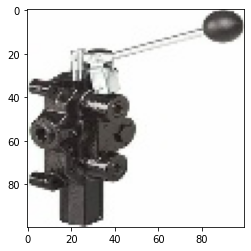

In [ ]:
#Getting examples of data 
randint = np.random.randint(len(df_img_text))
print(df_img_text['title'].iloc[randint])
print(df_img_text['description_clean'].iloc[randint])
print(df_img_text['description'].iloc[randint])
print(df_img_text['pred_labels'].iloc[randint])
plt.imshow(df_img_text['array'].iloc[randint])

In [ ]:
df_img_only['pred_labels'] = labels_image_only
df_img_only.replace({'pred_labels':di1}, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Fiskars 7854 X25 28-Inch Splitting Axe
All Beauty


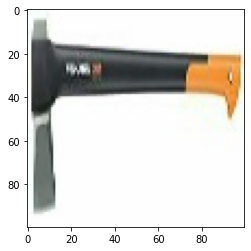

In [ ]:
randint = np.random.randint(len(df_img_only))
print(df_img_only['title'].iloc[randint])
#print(df_img_text['description_clean'].iloc[randint])
#print(df_img_text['description'].iloc[randint])

print(df_img_text['pred_labels'].iloc[randint])
plt.imshow(df_img_only['array'].iloc[randint])

In [ ]:
#Prepare df for submission
df_submission = pd.concat([df_text_only, df_img_only, df_img_text])
df_submission = df_submission[['ImgId','pred_labels']]
df_submission.replace({'pred_labels':di2}, inplace=True)
df_submission.columns = ['ImgId', 'category']
df_submission

,ImgId,category
ImgId,,
B0006IK25E,B0006IK25E,10
B000GBRO16,B000GBRO16,10
B000H6OZGW,B000H6OZGW,10
B000BR28KC,B000BR28KC,10
B0006IK27M,B0006IK27M,10
...,...,...
B00000JDGO,B00000JDGO,0
B00BE5DDQI,B00BE5DDQI,1
B00001SIGU,B00001SIGU,0


In [ ]:
image_filters = os.listdir(test_path)
image_filters = [x[:-4] for x in image_filters]

df_submission_filtered = df_submission[df_submission['ImgId'].isin(image_filters)]
df_submission_filtered

,ImgId,category
ImgId,,
B0052E5MM0,B0052E5MM0,18
B000SCYYQG,B000SCYYQG,12
B0000223EH,B0000223EH,5
B00004WCI3,B00004WCI3,5
B0006I3L8O,B0006I3L8O,2
...,...,...
B00000JDGO,B00000JDGO,0
B00BE5DDQI,B00BE5DDQI,1
B00001SIGU,B00001SIGU,0


In [ ]:
#final submission
df_submission_filtered.to_csv('/content/drive/MyDrive/Colab Notebooks/kaggle_retail_submission.csv', index = False)